# ISCE Processing of SnowEx UAVSAR data
By: **Jack Tarricone** *(University of Nevada, Reno)*, **Sam Neitlich** *(Montana State/JPL)*, **Talib Oliver** *(JPL)* \
Guidance from: **Yunling Lou** *(JPL)*, **Karen An** *(JPL)*, **Zach Keskenin** *(Boise State)*, **Ross Palomaki** *(Montana State)*, **Naheem Adebisi** *(Boise State)*

Create new conda environment to install ISCE in:
```
conda config --add channels conda-forge
conda config --set channel_priority strict
conda create -n isce2_env python=3.9 isce2=2.5.2 ** add numpy, glob, matplotlib
conda activate isce2_env
```

In the terminal, navigate to the home directory and open your ```.zprofile``` or ```.bash_profile```. In this case I'm using the [Atom](https://atom.io/) text editor:
```
cd ~
atom .zprofile
```

Add these lines or that path to where you ```conda``` enviroments are stored. Note that miniconda3 and be replace with anaconda3:
```
export ISCE_HOME=~/miniconda3/envs/isce2_env/lib/python3.9/site-packages/isce
export ISCE_STACK=~/miniconda3/envs/isce2_env/share/isce2/stripmapStack
export PATH=$PATH:$ISCE_HOME/bin:$ISCE_HOME/applications:$ISCE_STACK
```

Add link for copying extra pythons scripts here

Back in the terminal:
```
source .zprofile
```

In [2]:
%matplotlib inline
import isce
import os
import glob
import numpy as np
import shutil
from osgeo import gdal
import matplotlib.pyplot as plt
#import rasterio as rio
#import uavsar_pytools

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


This tutorial is a recreation of the processing steps outlined [IsceUAVSARprocessing.ipynb](https://github.com/taliboliver/Isce_UAVSAR/blob/master/IsceUAVSARprocessing.ipynb), with addtional functionality added by the ```uavsar_pytools``` package. It is assumed that users have ISCE installed on thier local machines, which admittedly can be the most challenging step in this process.  For information on ISCE installation please see the [Isce_UAVSAR](https://github.com/taliboliver/Isce_UAVSAR) by **Talib Oliver** *(JPL)* or Eric fieldings (find link from Zach)

In this notebook, we will interfermoterically process SLC stack from the Jemez Mountains, NM using the [Interferometric synthetic aperture radar Scientific Computing Environment (ISCE2)](https://github.com/isce-framework/isce2). We will then phase unwrap using [SNAPHU](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/), and geolocate the SLC data using ```geolocate_uavsar()```.

Past tutorials have assumed that your Jupyter environment will natively run command line code. In this notebook will run ISCE using mostly Python functionality.

## Create folder to work out of
First we'll create a new folder in our home directory to download files and run ISCE from

In [3]:
# get home dir
home = '/Users/jtarrico/'
os.chdir(home)
os.getcwd()

'/Users/jtarrico'

In [4]:
# working folder name
isce_directory = 'sierra_isce'
    
# path to folder
working_dir = os.path.join(home,isce_directory)

In [5]:
# make new folder
# os.mkdir(working_dir)
print("Directory '%s' created" %isce_directory)

Directory 'sierra_isce' created


In [6]:
# nativate to new folder
os.chdir(working_dir)
os.getcwd()

'/Users/jtarrico/sierra_isce'

In [7]:
## create subdirectories

# download
dl = 'download'
download_path = os.path.join(working_dir,dl)
# os.mkdir(download_path)

# slc
SLC = 'SLC'
slc_path = os.path.join(working_dir,SLC)
# os.mkdir(slc_path)

# baselines
bl = 'baselines'
baselines_path = os.path.join(working_dir,bl)
# os.mkdir(baselines_path)

# referenceShelve
rs = 'referenceShelve'
referenceShelve_path = os.path.join(working_dir,rs)
# os.mkdir(referenceShelve_path)

# dem
dem = 'DEM'
dem_path = os.path.join(working_dir,dem)
# os.mkdir(dem_path)

# igrams
igrams = 'igrams'
igrams_path = os.path.join(working_dir,igrams)
# os.mkdir(igrams_path)

In [22]:
# check folders were created
for file in os.listdir(working_dir):
    d = os.path.join(working_dir, file)
    if os.path.isdir(d):
        print(d)

/Users/jtarrico/sierra_isce/download_orginal
/Users/jtarrico/sierra_isce/SLC
/Users/jtarrico/sierra_isce/referenceShelve
/Users/jtarrico/sierra_isce/igrams
/Users/jtarrico/sierra_isce/download
/Users/jtarrico/sierra_isce/DEM
/Users/jtarrico/sierra_isce/baselines


## Data Download

Data links can be found on the UAVSAR site [here](https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=alamos_35915_01#data"). In this case we'll be using SLCs from Feb 12th and 26th, both the LLH and LKV files, 1x1 pixel spacing, and just the HH polarization. By selecting these options, the site generates the list of ```wget``` download commands below.

 <p align="center">
  <img width="600" src="imgs/uavsar_data_portal.png">
</p>     
<p style="text-align: center;">
    (Data download screen)
</p>

Here the links are formatted as a string and saved as an exeutable shell file (.sh). This can also be down outside of this notebook by copying the links directly from the UAVSAR data portal and saving into your local text editor.

In [23]:
# nativate to download folder
os.chdir(download_path)
os.getcwd()

'/Users/jtarrico/sierra_isce/download'

In [9]:
# create .sh file from links

links = ['wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC.dop',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC_s1_2x8.llh',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC_s1_2x8.lkv',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20002_001_200131_L090VV_01_BC_s1_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20002_001_200131_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20006_002_200212_L090VV_01_BC_s1_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20006_002_200212_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20009_023_200219_L090VV_01_BC_s1_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20009_023_200219_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20014_000_200226_L090VV_01_BC_s1_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20014_000_200226_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20016_005_200311_L090VV_01_BC_s1_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20016_005_200311_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC_s2_2x8.llh',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC_s2_2x8.lkv',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20002_001_200131_L090VV_01_BC_s2_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20002_001_200131_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20006_002_200212_L090VV_01_BC_s2_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20006_002_200212_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20009_023_200219_L090VV_01_BC_s2_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20009_023_200219_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20014_000_200226_L090VV_01_BC_s2_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20014_000_200226_L090VV_01_BC.ann',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20016_005_200311_L090VV_01_BC_s2_2x8.slc',
         'wget https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_20016_005_200311_L090VV_01_BC.ann']

with open('downloads.sh', 'w') as f:
    for links in links:
        f.write(links)
        f.write('\n')

In [24]:
! sh downloads.sh

--2023-11-13 15:45:23--  https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC.dop
Resolving downloaduav2.jpl.nasa.gov (downloaduav2.jpl.nasa.gov)... 137.78.249.121
Connecting to downloaduav2.jpl.nasa.gov (downloaduav2.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224093 (219K)
Saving to: ‘sierra_17305_01_BC.dop’

sierra_17305_01_BC. 100%[===================>] 218.84K   626KB/s    in 0.3s    

2023-11-13 15:45:24 (626 KB/s) - ‘sierra_17305_01_BC.dop’ saved [224093/224093]

--2023-11-13 15:45:24--  https://downloaduav2.jpl.nasa.gov/Release30/sierra_17305_01/sierra_17305_01_BC_s1_1x1.llh
Resolving downloaduav2.jpl.nasa.gov (downloaduav2.jpl.nasa.gov)... 137.78.249.121
Connecting to downloaduav2.jpl.nasa.gov (downloaduav2.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uavsar.jpl.nasa.gov [following]
--2023-11-13 15:45:24--  https://uavsar.j

In [25]:
# list files downloaded
for i in os.listdir(download_path):
    file = os.path.join(download_path, i)
    print(file)

/Users/jtarrico/sierra_isce/download/sierra_17305_20002_001_200131_L090VV_01_BC_s2_1x1.slc
/Users/jtarrico/sierra_isce/download/sierra_17305_20009_023_200219_L090VV_01_BC.ann
/Users/jtarrico/sierra_isce/download/sierra_17305_20009_023_200219_L090VV_01_BC_s2_1x1.slc
/Users/jtarrico/sierra_isce/download/sierra_17305_01_BC_s2_1x1.lkv
/Users/jtarrico/sierra_isce/download/sierra_17305_20006_002_200212_L090VV_01_BC_s1_1x1.slc
/Users/jtarrico/sierra_isce/download/sierra_17305_20014_000_200226_L090VV_01_BC_s1_1x1.slc
/Users/jtarrico/sierra_isce/download/.DS_Store
/Users/jtarrico/sierra_isce/download/sierra_17305_01_BC.dop
/Users/jtarrico/sierra_isce/download/sierra_17305_20016_005_200311_L090VV_01_BC_s2_1x1.slc
/Users/jtarrico/sierra_isce/download/sierra_17305_20006_002_200212_L090VV_01_BC.ann
/Users/jtarrico/sierra_isce/download/sierra_17305_01_BC_s1_1x1.lkv
/Users/jtarrico/sierra_isce/download/sierra_17305_20009_023_200219_L090VV_01_BC_s1_1x1.slc
/Users/jtarrico/sierra_isce/download/sierra_1

## Prepare SLC Stack

In [26]:
# nativate to download folder
os.chdir(working_dir)
os.getcwd()

'/Users/jtarrico/sierra_isce'

In [27]:
# copy doppler file to working directory
shutil.copy("/Users/jtarrico/sierra_isce/download/sierra_17305_01_BC.dop", 
            "/Users/jtarrico/sierra_isce/sierra_17305_01_BC.dop")

'/Users/jtarrico/sierra_isce/sierra_17305_01_BC.dop'

In [28]:
# check function inputs
! prepareUAVSAR_coregStack_segmets.py -h

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
usage: prepareUAVSAR_coregStack_segmets.py [-h] -i INPUT -d DOPFILE -o OUTPUT
                                           [-s SEGMENT] [-t TEXT_CMD]

Unzip Alos zip files.

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        directory which has all dates as directories. Inside
                        each date, zip files are expected.
  -d DOPFILE, --dop_file DOPFILE
                        Doppler file for the stack.
  -o OUTPUT, --output OUTPUT
                        output directory which will be 

In this case our -i flag will the the download folder, the -d flag will be the doppler file, -o will be the SLC directory.

In [29]:
! prepareUAVSAR_coregStack_segmets.py --input download/ --dop_file sierra_17305_01_BC.dop --output SLC --segment 1

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
['download/sierra_17305_20006_002_200212_L090VV_01_BC_s1_1x1.slc', 'download/sierra_17305_20014_000_200226_L090VV_01_BC_s1_1x1.slc', 'download/sierra_17305_20009_023_200219_L090VV_01_BC_s1_1x1.slc', 'download/sierra_17305_20002_001_200131_L090VV_01_BC_s1_1x1.slc', 'download/sierra_17305_20016_005_200311_L090VV_01_BC_s1_1x1.slc']
download/sierra_17305_20006_002_200212_L090VV_01_BC.ann
12-Feb-2020 22:11:03 UTC
20200212T2211
download/sierra_17305_20006_002_200212_L090VV_01_BC.ann
unpackFrame_UAVSAR_segments.py -i download/sierra_17305_20006_002_200212_L090VV_01_BC.ann -d sier

In [35]:
# segment 2
! prepareUAVSAR_coregStack_segmets.py --input download/ --dop_file sierra_17305_01_BC.dop --output SLC --segment 2

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
['download/sierra_17305_20002_001_200131_L090VV_01_BC_s2_1x1.slc', 'download/sierra_17305_20009_023_200219_L090VV_01_BC_s2_1x1.slc', 'download/sierra_17305_20016_005_200311_L090VV_01_BC_s2_1x1.slc', 'download/sierra_17305_20014_000_200226_L090VV_01_BC_s2_1x1.slc', 'download/sierra_17305_20006_002_200212_L090VV_01_BC_s2_1x1.slc']
download/sierra_17305_20002_001_200131_L090VV_01_BC.ann
31-Jan-2020 19:03:03 UTC
20200131T1903
download/sierra_17305_20002_001_200131_L090VV_01_BC.ann
unpackFrame_UAVSAR_segments.py -i download/sierra_17305_20002_001_200131_L090VV_01_BC.ann -d sier

In [17]:
# list folders just created in slc path
!ls SLC/*

SLC/20200131T1903:
data.db
sierra_17305_20002_001_200131_L090VV_01_BC_s1_2x8.slc
sierra_17305_20002_001_200131_L090VV_01_BC_s1_2x8.slc.ann
sierra_17305_20002_001_200131_L090VV_01_BC_s1_2x8.slc.vrt
sierra_17305_20002_001_200131_L090VV_01_BC_s1_2x8.slc.xml
sierra_17305_20002_001_200131_L090VV_01_BC_s2_2x8.slc
sierra_17305_20002_001_200131_L090VV_01_BC_s2_2x8.slc.ann
sierra_17305_20002_001_200131_L090VV_01_BC_s2_2x8.slc.vrt
sierra_17305_20002_001_200131_L090VV_01_BC_s2_2x8.slc.xml

SLC/20200212T2211:
data.db
sierra_17305_20006_002_200212_L090VV_01_BC_s1_2x8.slc
sierra_17305_20006_002_200212_L090VV_01_BC_s1_2x8.slc.ann
sierra_17305_20006_002_200212_L090VV_01_BC_s1_2x8.slc.vrt
sierra_17305_20006_002_200212_L090VV_01_BC_s1_2x8.slc.xml
sierra_17305_20006_002_200212_L090VV_01_BC_s2_2x8.slc
sierra_17305_20006_002_200212_L090VV_01_BC_s2_2x8.slc.ann
sierra_17305_20006_002_200212_L090VV_01_BC_s2_2x8.slc.vrt
sierra_17305_20006_002_200212_L090VV_01_BC_s2_2x8.slc.xml

SLC/20200219T2208:
data.db
sierr

In [30]:
os.getcwd()

'/Users/jtarrico/sierra_isce'

In [33]:
# using gdal info the check everything worked
! gdalinfo SLC/20200131T1903/sierra_17305_20002_001_200131_L090VV_01_BC_s1_1x1.slc

Driver: ISCE/ISCE raster
Files: SLC/20200131T1903/sierra_17305_20002_001_200131_L090VV_01_BC_s1_1x1.slc
       SLC/20200131T1903/sierra_17305_20002_001_200131_L090VV_01_BC_s1_1x1.slc.xml
Size is 8874, 66664
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (0.000000000000000,0.000000000000000)
Pixel Size = (1.000000000000000,1.000000000000000)
Corner Coordinates:
Upper Left  (   0.0000000,   0.0000000) (  0d 0' 0.01"E,  0d 0' 0.01"N)
Lower Left  (       0.000,   66664.000) 

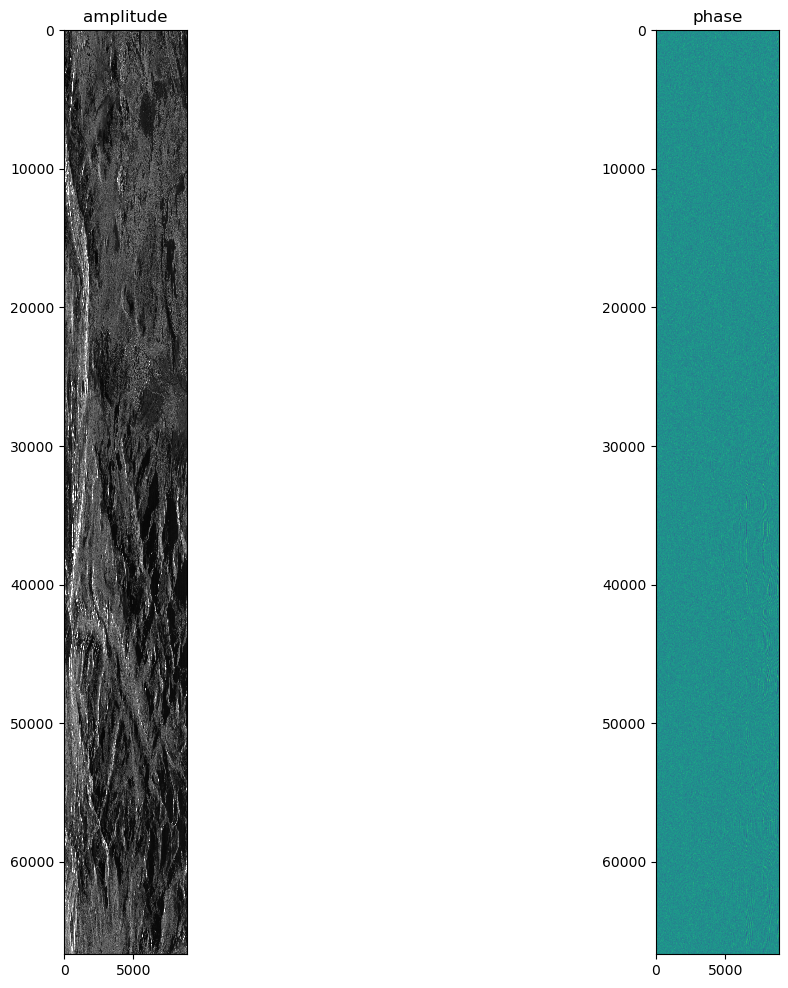

In [34]:
ds = gdal.Open("/Users/jtarrico/sierra_isce/SLC/20200131T1903/sierra_17305_20002_001_200131_L090VV_01_BC_s1_1x1.slc", gdal.GA_ReadOnly)
# extract a part of the SLC to display
x0 = 0
y0 = 0
x_offset = 8874
y_offset = 66664 
slc = ds.GetRasterBand(1).ReadAsArray(x0, y0, x_offset, y_offset)
ds = None

fig = plt.figure(figsize=(14, 12))

# display amplitude of the slc
ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(slc), vmin = 0, vmax=1, cmap='gray')
ax.set_title("amplitude")

#display phase of the slc
ax = fig.add_subplot(1,2,2)
ax.imshow(np.angle(slc))
ax.set_title("phase")

plt.show()

slc = None

## Create Interferograms
more info here.....

In [36]:
! uavsar_crossmul.py -h 

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
usage: uavsar_crossmul.py [-h] -s SLCDIR [-n NUMCONNECTIONS] [-o OUTDIR]
                          [-a AZLOOKS] [-r RGLOOKS]

Generate offset field between two Sentinel swaths

optional arguments:
  -h, --help            show this help message and exit
  -s SLCDIR, --slc_dir SLCDIR
                        Directory with all SLC subdirectories
  -n NUMCONNECTIONS, --num_connections NUMCONNECTIONS
                        Directory with all SLC subdirectories
  -o OUTDIR, --outdir OUTDIR
                        Prefix of output int and amp files
  -a AZLOOKS, --alks AZLOOKS
 

In [39]:
! uavsar_crossmul.py --slc_dir SLC/ --alks 8 --rlks 2 --num_connections 1 --outdir igrams 

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
generating  igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211
GDAL open (R): /Users/jtarrico/sierra_isce/SLC/20200131T1903/sierra_17305_20002_001_200131_L090VV_01_BC_s2_1x1.slc.vrt
GDAL open (R): /Users/jtarrico/sierra_isce/SLC/20200212T2211/sierra_17305_20006_002_200212_L090VV_01_BC_s1_1x1.slc.vrt
API open (WR): igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int
API open (WR): igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp
Completed set State
 Max threads used:           16
 FFT length:        16384
 wisdomFile, length =   

In [65]:
# print current directories
! ls igrams/*/*

igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp.xml
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh.xml
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int.xml
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp.xml
igrams/20200131T1903_20200

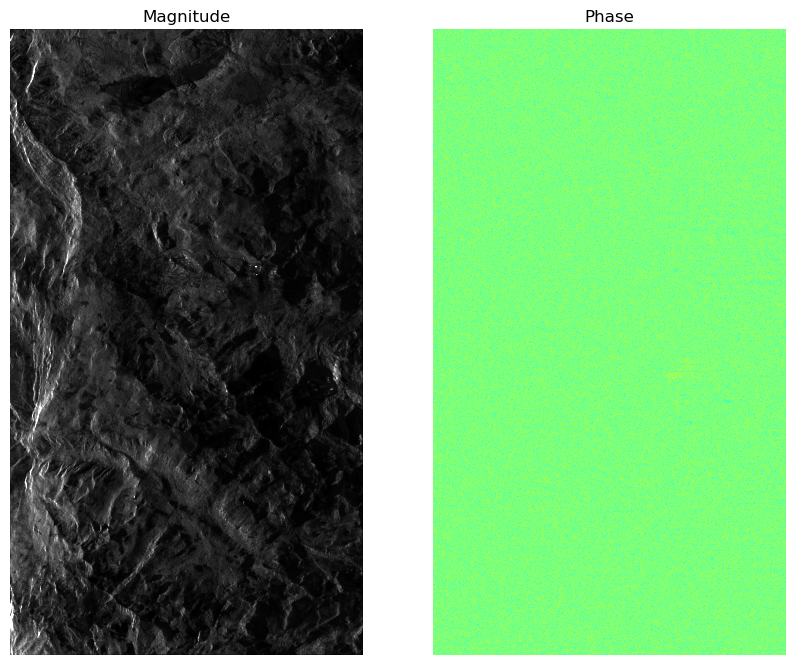

In [66]:
# plot amplitude and wrapped interferogram

w_int = 'igrams/20200226T2253_20200311T1852/20200226T2253_20200311T1852.int'
ds = gdal.Open(w_int, gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(igram), vmin = 0 , vmax = 8.0, cmap = 'gray')
ax.set_title("Magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,2,2)
ax.imshow(np.angle(igram), cmap = 'jet')
ax.set_title("Phase")
ax.set_axis_off()

# Phase Unwrapping

In [57]:
# create text file of date list
## this doesn't work, had to fix manually
! ls igrams/ | awk -F "/" '{print $1}' >> datelist.txt

In [71]:
# print contents of that file
with open('datelist.txt') as f:
    lines = f.readlines()
    print(lines)

['20200226T2253_20200311T1852']


In [72]:
! unwrap.py -h

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
usage: unwrap.py [-h] -i INTFILE -u UNWPREFIX -c COHFILE [--nomcf]
                 [-a AZLOOKS] [-r RGLOOKS] [-d DEFOMAX] [-s REFERENCE]
                 [-m METHOD]

Unwrap interferogram using snaphu

optional arguments:
  -h, --help            show this help message and exit
  -i INTFILE, --ifg INTFILE
                        Input interferogram
  -u UNWPREFIX, --unwprefix UNWPREFIX
                        Output unwrapped file prefix
  -c COHFILE, --coh COHFILE
                        Coherence file
  --nomcf               Run full snaphu and not in MCF mode
  -a AZLOO

In [74]:
# run snaphu, this will take a while
! awk -F "_" '{print "unwrap.py -i igrams/"$1"_"$2"/"$1"_"$2".int -u igrams/"$1"_"$2"/"$1"_"$2".unw -c igrams/"$1"_"$2"/"$1"_"$2".coh -a 12 -r 3 -s SLC/"$1"/ -m snaphu"}' datelist.txt >> unwall.sh

In [ ]:
! sh unwall.sh

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
snaphu
igrams/20200226T2253_20200311T1852/referenceShelve/data
unwrapping method :  snaphu

snaphu v1.4.2
Reading wrapped phase from file igrams/20200226T2253_20200311T1852/20200226T2253_20200311T1852.int
No weight file specified.  Assuming uniform weights
Reading correlation data from file igrams/20200226T2253_20200311T1852/20200226T2253_20200311T1852.coh
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm


In [67]:
# list files generated in unwrapping process
!ls igrams/*/*

igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.amp.xml
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh.xml
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int.xml
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp.vrt
igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp.xml
igrams/20200131T1903_20200

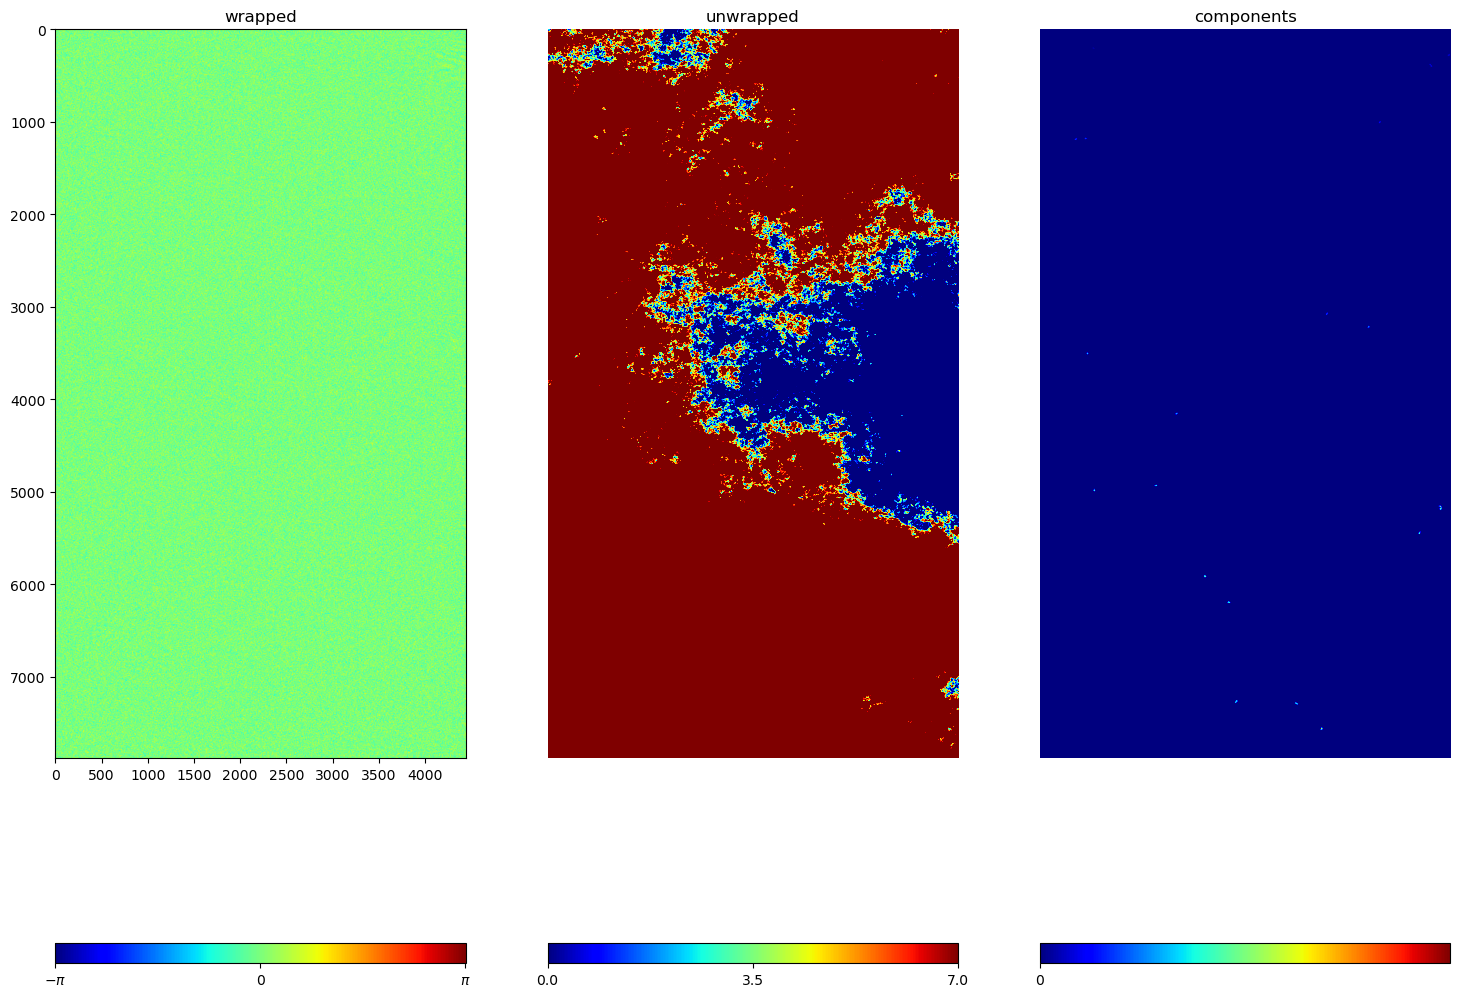

In [68]:
# plot

# reading the multi-looked wrapped interferogram
ds = gdal.Open("igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

# reading the multi-looked unwrapped interferogram
ds = gdal.Open("igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw", gdal.GA_ReadOnly)
igram_unw = ds.GetRasterBand(2).ReadAsArray()
ds = None

# reading the connected component file
ds = gdal.Open("igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.unw_snaphu.unw.conncomp", gdal.GA_ReadOnly)
connected_components = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
cax=ax.imshow(np.angle(igram), cmap='jet')
ax.set_title("wrapped")
#ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-3.14,0,3.14],orientation='horizontal')
cbar.ax.set_xticklabels(["$-\pi$",0,"$\pi$"])

ax = fig.add_subplot(1,3,2)
cax = ax.imshow(igram_unw, vmin = 0, vmax = 7, cmap = 'jet')
ax.set_title("unwrapped")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[0,3.5,7], orientation='horizontal')


ax = fig.add_subplot(1,3,3)
cax = ax.imshow(connected_components, cmap = 'jet')
ax.set_title("components")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[0,21] , orientation='horizontal')
cbar.ax.set_xticklabels([0,21])


connected_components = None